In [23]:
import pickle
df = pickle.load(open("/Users/zengyuxiang/Documents/科研代码/Master/Network_Detect/datasets/flow/IoT_all_x.pickle", "rb"))

In [24]:
all_flow_length = []
for i in range(len(df)):
    all_flow_length.append(len(df[i]))

===== Data Distribution Description =====
Number of Data Points: 344709
Mean: 40.96
Standard Deviation: 110.79
Minimum Value: 0
Maximum Value: 1320
Median: 15.0
25th Percentile: 4.0
75th Percentile: 28.0


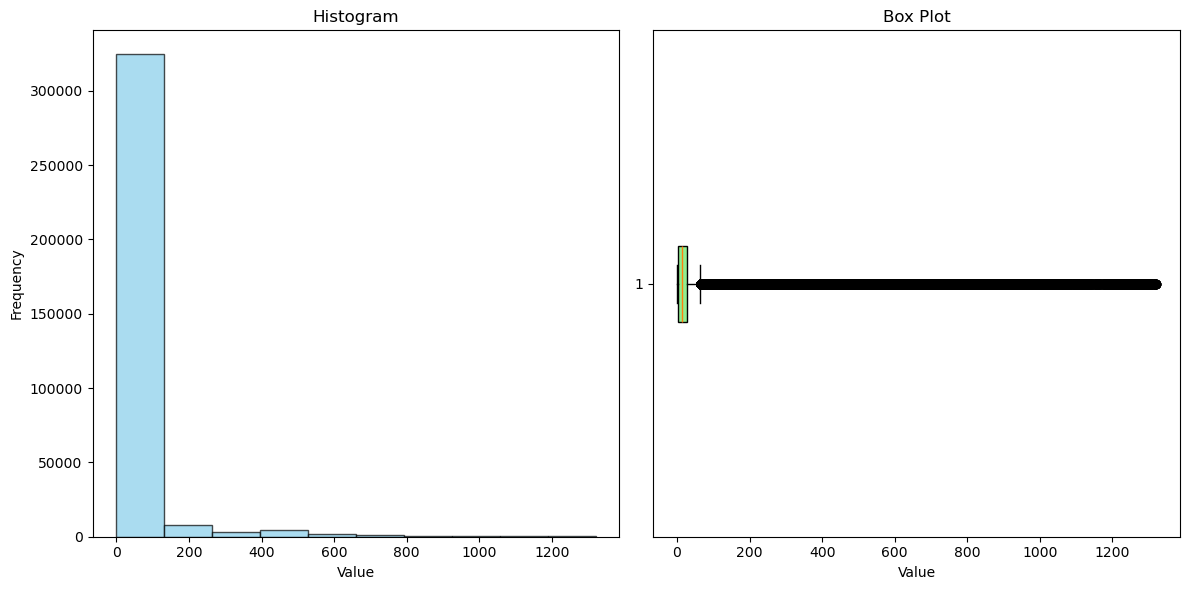

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Function to describe the data distribution
def describe_data(data):
    print("===== Data Distribution Description =====")
    print(f"Number of Data Points: {len(data)}")
    print(f"Mean: {np.mean(data):.2f}")
    print(f"Standard Deviation: {np.std(data):.2f}")
    print(f"Minimum Value: {np.min(data)}")
    print(f"Maximum Value: {np.max(data)}")
    print(f"Median: {np.median(data)}")
    print(f"25th Percentile: {np.percentile(data, 25)}")
    print(f"75th Percentile: {np.percentile(data, 75)}")
    print("========================================")

    # Visualization of the data distribution
    plt.figure(figsize=(12, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(data, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title("Histogram")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

    # Box Plot
    plt.subplot(1, 2, 2)
    plt.boxplot(data, vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen', color='black'))
    plt.title("Box Plot")
    plt.xlabel("Value")

    plt.tight_layout()
    plt.show()

# Call the function to describe data
describe_data(all_flow_length)

In [26]:
for i in range(950, 1001):
    print(f"{i * 0.1:.1f}% 包序列，流的长度: {np.percentile(all_flow_length, i * 0.1)}")

95.0% 包序列，流的长度: 157.0
95.1% 包序列，流的长度: 161.0
95.2% 包序列，流的长度: 166.0
95.3% 包序列，流的长度: 172.0
95.4% 包序列，流的长度: 179.0
95.5% 包序列，流的长度: 190.0
95.6% 包序列，流的长度: 202.0
95.7% 包序列，流的长度: 210.0
95.8% 包序列，流的长度: 219.0
95.9% 包序列，流的长度: 225.0
96.0% 包序列，流的长度: 230.0
96.1% 包序列，流的长度: 236.0
96.2% 包序列，流的长度: 244.0
96.3% 包序列，流的长度: 257.0
96.4% 包序列，流的长度: 267.0
96.5% 包序列，流的长度: 272.0
96.6% 包序列，流的长度: 279.0
96.7% 包序列，流的长度: 293.0
96.8% 包序列，流的长度: 312.0
96.9% 包序列，流的长度: 336.0
97.0% 包序列，流的长度: 350.0
97.1% 包序列，流的长度: 365.0
97.2% 包序列，流的长度: 381.0
97.3% 包序列，流的长度: 393.0
97.4% 包序列，流的长度: 398.0
97.5% 包序列，流的长度: 402.0
97.6% 包序列，流的长度: 406.0
97.7% 包序列，流的长度: 411.0
97.8% 包序列，流的长度: 421.0
97.9% 包序列，流的长度: 432.0
98.0% 包序列，流的长度: 438.0
98.1% 包序列，流的长度: 443.0
98.2% 包序列，流的长度: 453.0
98.3% 包序列，流的长度: 473.0
98.4% 包序列，流的长度: 487.0
98.5% 包序列，流的长度: 501.0
98.6% 包序列，流的长度: 521.0
98.7% 包序列，流的长度: 547.0
98.8% 包序列，流的长度: 568.0
98.9% 包序列，流的长度: 599.0
99.0% 包序列，流的长度: 636.0
99.1% 包序列，流的长度: 671.6280000000261
99.2% 包序列，流的长度: 705.0
99.3% 包序列，流的长度: 729.0
99.4% 包序列，流的长度: 755.

18

In [58]:
[i + 1 for i in range(21)]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]